Fashion-AI-segmentation
===================

```Source Code``` : https://github.com/anish9/Fashion-AI-segmentation

상의와 전체 복장에 대한 segmentation을 진행하는 프로그램
--------

# 폴더 설명

```model``` : weights, model parameters를 저장한 폴더  
  
```output_instance_Segmentation``` : instance_segmentation.py 결과 저장한 폴더(mask 형태 이미지)  
  
```result``` : fashion.py 결과를 저장한 폴더(옷만 분리된 이미지)  
  
```sample``` : 시험용 이미지 데이터를 저장한 폴더  
  
```semantic-future``` : 원본 이미지, 마스크 이미지, 옷만 분리된 이미지를 예제로 저장한 폴더
  
  

# 파일 설명


```fashion.py``` : CNN 학습 후 image segmentation 진행한 이미지를 반환   
```instance_segmentation.py``` :  마스크 이미지 반환
  
    
       

# README 설명

#### Image-Processing Resource 
#### GrabCut   
GrabCut 알고리즘은 이미지에서 배경이 아닌 전경에 해당하는 이미지를 추출해 내는 방법입니다. 이미지에서 한번에 전경을 추출해 내는 것이 아닌 사용자와의 상호 작용을 통해 단계적으로 전경을 추출합니다. 이 상호작용은 크게 2가지 단계로 진행되는데, 첫번째는 이미지에서 전경이 포함되는 영역을 사각형으로 대략적으로 지정합니다. 단, 이때 지정한 사각형 영역 안에는 전경이 모두 포함되어 있어야 합니다. 그리고 두번째는 첫번째에서 얻어진 전경 이미지의 내용중 포함되어진 배경 부분은 어디인지, 누락된 전경 부분은 어디인지를 마킹하면 이를 이용해 다시 전경 이미지가 새롭게 추출됩니다.

Reference : http://www.gisdeveloper.co.kr/?p=6747

### Deep Learning

Reference : https://en.wikipedia.org/wiki/Deep_learning  

### Package Requirements

1.Python

2.OpenCV 3.1.0

3.Keras with tensorflow backend

4.Pandas

5.NumPy

### Demo (AI-Segmentaion)

1.*clone* the Repo to your local pc ensuring that all the package requirements satisfied.<enter>
  
2.Run the code from the terminal **python fashion.py image1.jpg /Users/demo/save** <enter>
  
3.argument1 -- *image_name -- image1.jpg*, argument2 -- *save_directory -- /Users/demo/*
4.Visualize the results in your save_directory.

### Reference : https://mylifemystudy.tistory.com/67  

# fashion.py

In [ ]:
#josh.anish1@gmail.com
#the code has been created with an intention of previewing the entire project
#contributions are welcomed!!!
import cv2
import numpy as np
import os
import sys
import pandas as pd
# import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
from keras.layers import Dense

from keras.layers import Flatten,Dropout
from keras.models import model_from_json

# 이미지 파일 경로와 segmented된 이미지를 저장할 경로를 사용자로부터 입력받음
img_file = sys.argv[1] 
directory = sys.argv[2]

# 이미지 파일의 클래스를 예측하는 함수
def predictor(img_file):
    
    # 이미지를 읽어들이고 (1,64,64,3) shape으로 변환
    img = cv2.imread(img_file)  
    resize = cv2.resize(img,(64,64))    
    #resize = np.expand_dims(resize,axis=0)   
    img_fin = np.reshape(resize,[1,64,64,3]) 
    
    
    # model parameter가 저장된 json 파일을 읽어들이고 load한 후
    json_file = open('model/binaryfas10.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    # weights가 저장된 h5 파일을 읽어서 load함
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("model/binaryfashion.h5")
    # print("Loaded model from disk")
    
    # 각 데이터에 대한 클래스 예측
    prediction = loaded_model.predict_classes(img_fin)
    
    # 차원 사이즈가 1인 배열에 대해 차원을 제거하고 스칼라 값으로 바꿔준다
    # [[1], [2], [3]] --> [1,2,3]
    prediction = np.squeeze(prediction,axis=1)
    predict = np.squeeze(prediction,axis=0)
    return int(predict)

"""Neural Network Decoding"""
""" The coordinates are created and trained"""
"""-----------------"""
# 이미지 크기 지정
image_width = 300
image_height = 500


# 파일명을 문자열 형태로 반환하는 함수
def path_file(file):
    return str(file)

# 이미지 segmentation 진행하는 함수
def nn(img_file):
    
    # 이미지 파일에 대한 클래스를 예측하고 
    predict = predictor(img_file)
    file = path_file("annotation.csv")
    reader = pd.read_csv(file)
    print(predict)
    
    # 이미지 파일을 읽어들이고 위에서 지정한 이미지 크기로 shape 변환
    img = cv2.imread(img_file)
    img = cv2.resize(img,(image_width,image_height))
    #seg = image(image,reader.x1[predict],reader.y1[predict],reader.x2[predict],reader.y2[predict],reader.i[predict])
    
    # image width, height 크기에  0으로 채운 배열 생성
    mask = np.zeros(img.shape[:2],np.uint8)   
    
    # (1, 65) 크기의 0 배열 생성
    bgdModel = np.zeros((1,65),np.float64)
    
    # (1, 65) 크기의 0 배열 생성 
    fgdModel = np.zeros((1,65),np.float64)
    
    # grabCut할 사각형 영역을 지정
    rect = (reader.x1[predict],reader.y1[predict],reader.x2[predict],reader.y2[predict])
    
    # 인자 살펴보기
    # img : 이미지
    # mask : 모든 요소가 0인 마스크 이미지
    # rect : 사각형 영역
    # bgdModel : 
    # fgdModel : segment하고 싶은 픽셀값이 설정됨(0,2는 배경, 1,3은 segment하고 싶은 이미지 부분)
    # reader.i[predict] : 해당 알고리즘의 반복 수행 횟수
    # cv2.GC_INIT_WITH_RECT : 사각형을 통한 grabCut일 경우 지정해줌
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,reader.i[predict],cv2.GC_INIT_WITH_RECT)
    
    # segment하고 싶은 부분만 저장한다(0,2만 골라냄)
    # mask값이 0이거나 2일 경우에 0을 반환하고 거짓일 경우 1을 반환한다
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    # 원본 이미지에 mask2를 곱해 segmented된 이미지로 변환
    img_cut = img*mask2[:,:,np.newaxis]
    
    # 위에서 지정한 디렉터리에 지정한 파일명으로 저장
    new_img_file = img_file.split('/')[-1]
    cv2.imwrite(directory+"/"+str(img_file),img_cut)

nn(img_file)

## fashion.py 이해하는 데 도움되는 부분

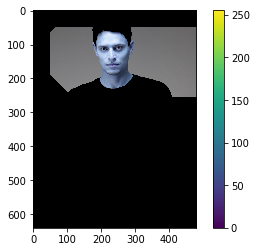

(<matplotlib.image.AxesImage at 0x1a19899cf60>,
 None)

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
 
img = cv2.imread('sample/inp3.jpg')
mask = np.zeros(img.shape[:2],np.uint8)
 
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
 
rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
 
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
 
plt.imshow(img),plt.colorbar(),plt.show()

In [3]:
import warnings 

warnings.filterwarnings('ignore')

json_file = open('model/binaryfas10.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
    
# weights가 저장된 h5 파일을 읽어서 load함
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model/binaryfashion.h5")
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

conv2d : https://www.tensorflow.org/api_docs/python/tf/layers/conv2d  
max_pooling2d : https://www.tensorflow.org/api_docs/python/tf/layers/MaxPooling2D  
flatten : https://www.tensorflow.org/api_docs/python/tf/layers/flatten  
dense : https://www.tensorflow.org/api_docs/python/tf/layers/dense  

# instance_segmentation.py


In [20]:
import cv2
import numpy as np
import os
import sys

# 이미지 파일 경로와 변환한 이미지를 저장할 디렉토리 위치 지정
img_file = sys.argv[1]
save_dir = sys.argv[2]

# 이미지 사이즈, 색상값 지정
img_size_x,img_size_y = 300,500
op_img_x,op_img_y = 1600,2300

contrast = 120
brightness = 0
pixel_factor = 127
default_tree = 40
create = cv2.GC_INIT_WITH_RECT

# 
def segment(img,x,y,w,z,iteration,savefile,rgbf,rgbb):
    imgs = cv2.imread(img)
    img = cv2.resize(imgs,(img_size_x,img_size_y))
    
    mask = np.zeros(img.shape[:2],np.uint8)   
    bgdModel = np.zeros((1,65),np.float64)
    
    fgdModel = np.zeros((1,65),np.float64)
    coord = (x,y,w,z)
    
    cv2.grabCut(img,mask,coord,bgdModel,fgdModel,iteration,create)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_cut = img*mask2[:,:,np.newaxis]
    
    # 마스크 이미지 사이즈로 shape 변환 및 데이터 타입 변환
    rese = cv2.resize(img_cut,(op_img_x,op_img_y))
    img_cont = np.int16(rese) 
    
    # 이미지 색상 변환
    img_cont = img_cont*(contrast/1) - contrast + brightness
    img_cont = np.clip(img_cont, 0, 255)
    opr = np.uint8(img_cont)
    op1 = opr[np.where((opr == [255,255,255]).all(axis = 2))] = rgbf
    op2 = opr[np.where((opr == [0,0,0]).all(axis = 2))] = rgbb
    
    cv2.imwrite(save_dir+str(savefile),opr)

p1 = 80-5
p2 = 10-5
p3 = 195-5
p4 = 420+80
x_po,y_po,w_po,z_po = p1,p2,p3,p4

segment(img_file,x_po,y_po,w_po,z_po,default_tree,img_file,[255,0,0],[0,255,0])

# 실행 결과


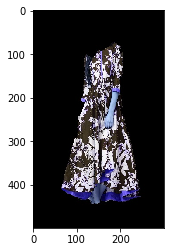

In [30]:
plt.imshow(cv2.imread('result/inp2.jpg'))

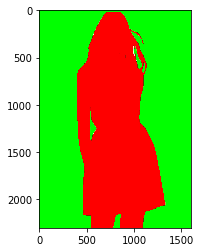

In [31]:
plt.imshow(cv2.imread('output_instance_Segmentation/test1.jpg'))

# 한계


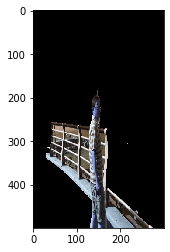

In [32]:
plt.imshow(cv2.imread('result/inp9.jpg'))

배경 이미지가 복잡할 경우 segmentation이 제대로 진행되지 않음  